# CS216 : Assignment 2

Reading: Review your class notes, Klette Chapter 1.2-1.3,
Szeliski Chapter 2,3 and/or Forsyth and Ponce Chapters 1,4,8,9

For written problems, you can either use Markdown/LaTeX to directly enter your reponse in the provided notebook cell, or if you prefer, write out by hand and embed a photo of your solution. For coding problems, I have provided some suggestion of how to structure your code but feel free to modify or ignore as you see fit.

Please edit the cell below to include your name and student ID #

In [162]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import fft

import skimage
from skimage import io
from skimage import morphology
from skimage import feature
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from math import pi

from scipy import ndimage

## 1. Convolution versus Correlation

Prove that *convolution* is associative, that is  $(f \star g) \star h = f \star (g \star h)$

Prove that *correlation* is not associative (best done by showing a counter-example)

You should just show this for 1D signals and assume the signal has been extended periodically as we did in lecture (i.e. limits of the summation are $+/-\infty$ ) 


### Convolution is associative: 

(assuming continuous functions, hence the integral sign)

\begin{equation} f(t)  \otimes g(t) = \int\limits_{-\infty}^{\infty} f(x_1) \cdot g(t-x_1) \cdot \mathrm{d}x_1 \end{equation}
    
\begin{equation} [ f(t)  \otimes g(t) ] \otimes h(t)  =  \left( \int\limits_{-\infty}^{\infty} f(x_1) \cdot g(t-x_1) \cdot \mathrm{d}x_1 \right) \otimes h(t) 
\end{equation}

Equation 1:

\begin{equation}
   [ f(t)  \otimes g(t) ] \otimes h(t)  = \int\limits_{-\infty}^{\infty}\int\limits_{-\infty}^{\infty} f(x_1) \cdot g(x_2-x_1) \cdot  h(t-x_2) \cdot \mathrm{d}x_1 \cdot \mathrm{d}x_2 
\end{equation}




\begin{equation} g(t) \otimes h(t) = \int\limits_{-\infty}^{\infty} g(y_1) \cdot h(t-y_1) \cdot \mathrm{d}y_1
\end{equation}

\begin{equation} f(t) \otimes [ g(t) \otimes h(t) ] = f(t) \otimes \left( \int\limits_{-\infty}^{\infty} g(y_1) \cdot h(t-y_1) \cdot \mathrm{d}y_1  \right) 
\end{equation}

\begin{equation} f(t) \otimes [ g(t) \otimes h(t) ] = \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} f(y_2) \cdot  g(y_1) \cdot h(t-y_2-y_1) \cdot \mathrm{d}y_1 \cdot \mathrm{d}y_2 
\end{equation}

Equation 2:

\begin{equation}
   f(t) \otimes [ g(t) \otimes h(t) ] = \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} f(y_2) \cdot g((y_1+y_2)-y_2) \cdot h(t - (y_1+y_2)) \cdot \mathrm{d}y_1 \cdot \mathrm{d}y_2 
\end{equation}

Barring variable names, equations 1 and 2 have the same form. Hence, proved.

### Correlation is not associative:

Looking at correlation as a sliding windowed operation, consider $f = [5, 3, 4, 6]$ and $g = [-1 2 -1]$.
$(f * g)[1] = 7$, assuming zero-padding and 1-indexed arrays. On the other hand, $(g * f)[1] = -1$ i.e. $(f * g) \neq (g * f)$.

## 2. Fast Fourier Transform

If we have an image $I$ of dimension $H$x$W$ and we convolve it with a
filter $f$ of size $M$x$N$ using the spatial domain formula given in class,
what will the complexity be (i.e. how many multiplications)?  How about if we
use the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) "trick"?

### Answer:

Let's assume that if the original image is padded before convolution, the size of the padded image is comparable to the original image size (this is true if $H, W$ are much greater than $M, N$). For this case, 

$$ J[h, w] = \Sigma \Sigma f[m, n] \cdot I[h-m, w-n] $$

This comes to $M x N$ products for each pixel in $I$. The complexity is $\mathcal{O}(HW\cdot MN)$


By Convolution theorem, $ I \otimes f = \mathcal{F}^{-1}\{\mathcal{F}\{I\} \cdot \mathcal{F}\{f\} \} $.
$\mathcal{F}\{I\}$ takes $\mathcal{O}(HW \cdot log(HW))$. $\mathcal{F}\{f\}$ takes $\mathcal{O}(MN \cdot log(MN))$ and $\mathcal{F}^{-1}$ takes $\mathcal{O}(HW \cdot log(HW))$.

Hence, total complexity by FFT trick is $\mathcal{O}(HW \cdot log(HW))$ assuming $H, W$ are much greater than $M, N$.

## 3. Factorizing Filters
Starting with the formula for 2D convolution, show that if our filter is
the product of two functions, $f(x,y)=f_1(x)f_2(y)$, we can compute the
convolution more efficiently.  Is there a way to use this idea to speed up
convlution with a 2D isotropic Gaussian filter $g(x,y) = \frac{1}{2\pi\sigma^2}
\exp^{\frac{-(x^2 + y^2)}{2 \sigma^2}}$?

We have $f[x, y]=f_{1}[x] \cdot f_{2}[y]$.

\begin{aligned}
y[x, y]=f[x, y] \otimes g[x, y] &=\sum_{j=-\infty}^{\infty} \sum_{i=-\infty}^{\infty} f[i, j] \cdot g[x-i, y-j] \\
&=\sum_{j=-\infty}^{\infty} \sum_{i=-\infty}^{\infty} f_{1}[i] \cdot f_{2}[j] \cdot g[x-i, y-j] \\
&=\sum_{j=-\infty}^{\infty} f_{2}[j]\left(\sum_{i=-\infty}^{\infty} f_{1}[i] \cdot g[x-i, y-j]\right) \\
&=f_{2}[y] \otimes ( f_{1}[x] \otimes g[x, y] ) \\
&=f_{1}[x] \otimes ( f_{2}[y] \otimes g[x, y] )
\end{aligned}


For the Gaussian filter $g(x,y)$, we have $g_{1}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp^{\frac{-x^2}{2 \sigma^2}}$ and $g_{2}(y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp^{\frac{-y^2}{2 \sigma^2}}$.

We can convert 2D convolution to 2 1D convolutions one after the other.

## 4. Experimenting with the DFT

Import the appropriate functions from the numpy [fft module](https://numpy.org/doc/stable/reference/routines.fft.html) and carry out some experiments yourself. You will want to use the ***fftshift*** function to get the spectra like we showed in class where 0 is at the center

**4.1** Start out in 1D and make a signal which is of length 100 with a single
impulse of height 1 in the middle.  Compute the DFT of the signal and plot the
magnitude of the spectrum.

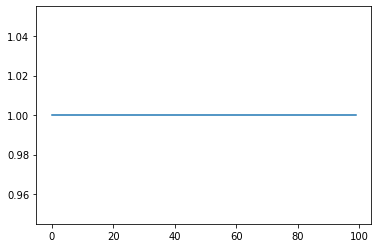

In [15]:
signal_delta = np.zeros(shape=100)
signal_delta[50] = 1

dft_delta = np.fft.fft(signal_delta)

plt.plot(np.abs(dft_delta))

**4.2** Now increase the width of the pulse from a single sample to a unit height
``box function'' 5 and 10 samples long and plot resulting the spectrum
magnitudes.

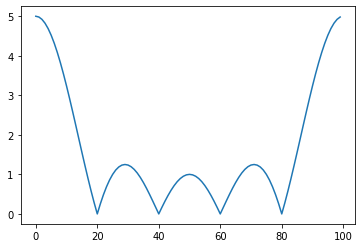

In [58]:
signal_box5 = np.zeros(shape=100)
signal_box5[47:52] = 1
dft_box5 = np.fft.fft(signal_box5)

plt.plot(np.abs(dft_box5))

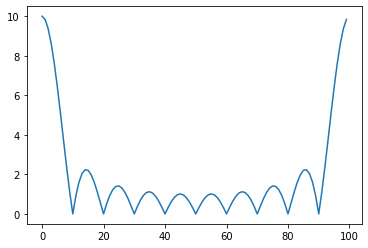

In [17]:
signal_box10 = np.zeros(shape=100)
signal_box10[45:55] = 1
dft_box10 = np.fft.fft(signal_box10)

plt.plot(np.abs(dft_box10))

**4.3** Now do the same for a Gaussian function with $\sigma = 1$
and $\sigma = 2$ (the Gaussian has infinite support but you should just analyze
a finite chunk centered around the origin).

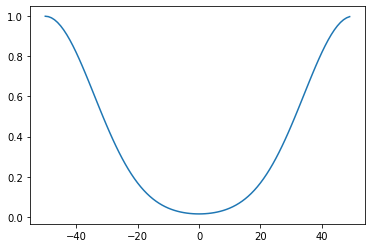

In [39]:
x = np.arange(-50, 50)
signal_gaussian1 = np.exp(-(x**2/2))/np.sqrt(2*pi)
dft_gaussian1 = np.fft.fft(signal_gaussian1)

plt.plot(np.arange(-50,50), np.abs(dft_gaussian1))

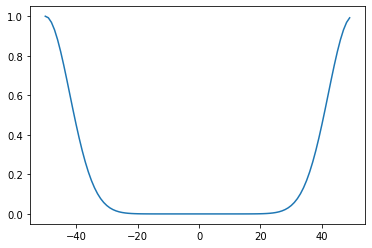

In [60]:
x = np.arange(-50, 50)
signal_gaussian2 = np.exp(-(x**2/8))/np.sqrt(2*pi*4)
dft_gaussian2 = np.fft.fft(signal_gaussian2)

plt.plot(np.arange(-50,50), np.abs(dft_gaussian2))

**4.4** Figure out how to do a 2D DFT and inverse DFT.  Replicate the experiment we showed in class (shown as
Figure 7.6 in Forsyth and Ponce) of swapping phase and magnitude by (1) computing the DFT of two images of the same size, (2) computing a new set of coefficents which have the phase from the first image and the mangitude from
the second image, (3) taking the inverse DFT of this combined spectrum to produce a new image.

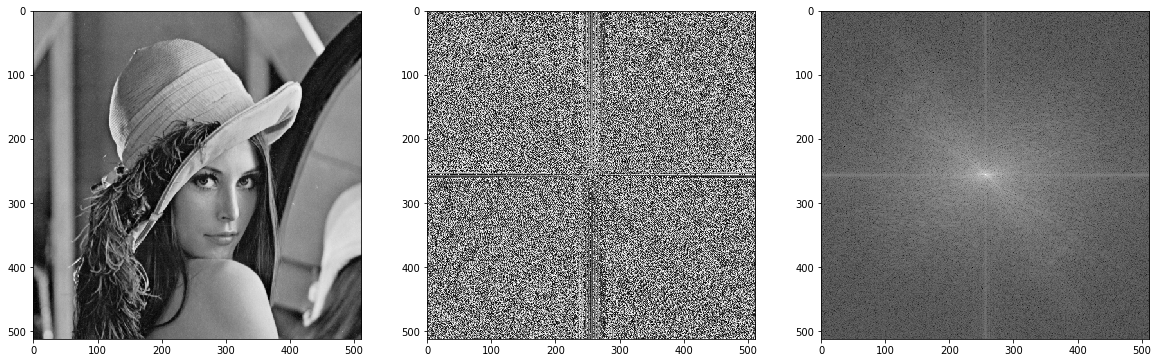

In [92]:
lenna = io.imread('lenna.png', as_gray=True)
dft_lenna = fft.fft2(lenna)
dft_lenna = fft.fftshift(dft_lenna)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(lenna, cmap='gray')
plt.subplot(132)
plt.imshow(np.angle(dft_lenna), cmap='gray')
plt.subplot(133)
plt.imshow(20*np.log(np.abs(dft_lenna)), cmap='gray') # decibel scale

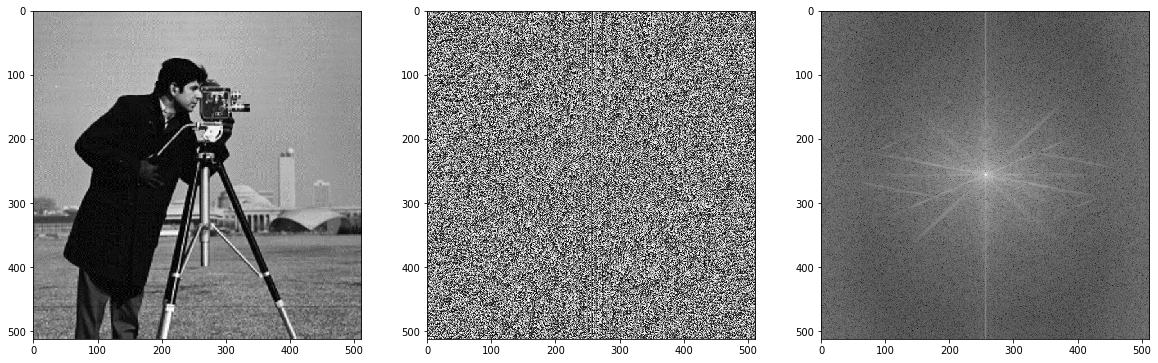

In [94]:
cameraman = io.imread('cameraman.jpg', as_gray=True)
dft_cameraman = fft.fft2(cameraman)
dft_cameraman = fft.fftshift(dft_cameraman)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(cameraman, cmap='gray')
plt.subplot(132)
plt.imshow(np.angle(dft_cameraman), cmap='gray')
plt.subplot(133)
plt.imshow(20*np.log(np.abs(dft_cameraman)), cmap='gray') # decibel scale

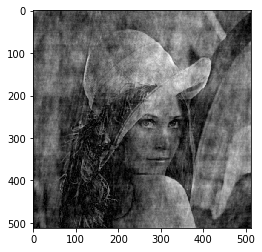

In [102]:
phase = np.angle(dft_lenna)
magnitude = np.abs(dft_cameraman)

dft_new_image = np.multiply(magnitude, np.exp(1j*phase))
new_image = fft.ifft2(dft_new_image)

plt.imshow(np.abs(np.real(new_image)), cmap='gray')

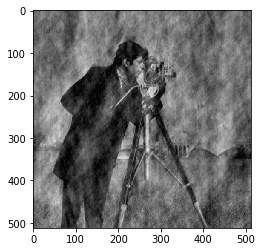

In [104]:
phase = np.angle(dft_cameraman)
magnitude = np.abs(dft_lenna)

dft_new_image = np.multiply(magnitude, np.exp(1j*phase))
new_image = fft.ifft2(dft_new_image)

plt.imshow(np.abs(np.real(new_image)), cmap='gray')

## 5. Edge Detection

Write a gradient based edge detector.  Your code should load in
an image and convert to grayscale floats.  Once you have loaded in the image, 
you should smooth the image with a
Gaussian filter and then compute horizontal and vertical derivatives using the
derivative filter described in lecture.  The amount of smoothing is determined
by the $\sigma$ of the Gaussian (which should be a parameter of your code).
You can use **scipy.ndimage.convolve2d** option to perform the required
convolutions. Once you have computed the derivatives in the $x$ and $y$
directions using convolution, compute the gradient magnitude and angle
and threshold the magnitude to find the edge pixels. To do non-maximum 
suppression, you can use **skimage.morphology.thin** in order
to get out a 1-pixel-wide version of the detected edges.

### 5.1 Implementation

In [136]:
def detect_edge(I, sigma):
    """
    Compute the gradient orientation and magnitude after
    smoothing I with a Gaussian filter with parameter sigma
    """
    # Gaussian filtering
    I_smooth = ndimage.gaussian_filter(I, sigma)
    
    # derivative filters (Sobel filter)
    dx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    dy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    # gradients along X and Y direction
    Ix = ndimage.convolve(I_smooth, dx)
    Iy = ndimage.convolve(I_smooth, dy)
    
    # absolute gradient values
    grad_I = np.abs(np.sqrt(Ix**2 + Iy**2))    
    grad_I = grad_I*255/np.max(grad_I)
    
    # angle (orientation) of the gradients
    theta_I = np.arctan2(Iy, Ix)
    
    # thresholding (see note below)
    thresh = threshold_otsu(grad_I)
    thresh_grad = grad_I > thresh
    
    # non-maximum suppression
    edges_I = morphology.thin(thresh_grad)
    
    return grad_I, theta_I, edges_I

### Note on thresholding

![Histogram of test image](hist1.png)
![Histogram of cheetah image](hist2.png)

These are the histograms of the gradients of the two images used for testing. The characteristics of both vary a lot and it wasn't easy to guess an appropriate thresholding value for a general image. That's why I used the Otsu threshold from [skimage.filters](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu).

### 5.2 Demonstration

For two images (the example below and an additional image of your choice), visualize the input image, gradient magnitude, angle and the edge detection output for two different settings of $\sigma$. This will yield 16 images inb total. You should make sure that the image is low enough resolution and the plots large enough to clearly see the results. For visualizing the orientation, you should use a circular colormap such as "twilight" or "hsv". You should include colorbars on your plots where appropriate so the range of values is visible. 

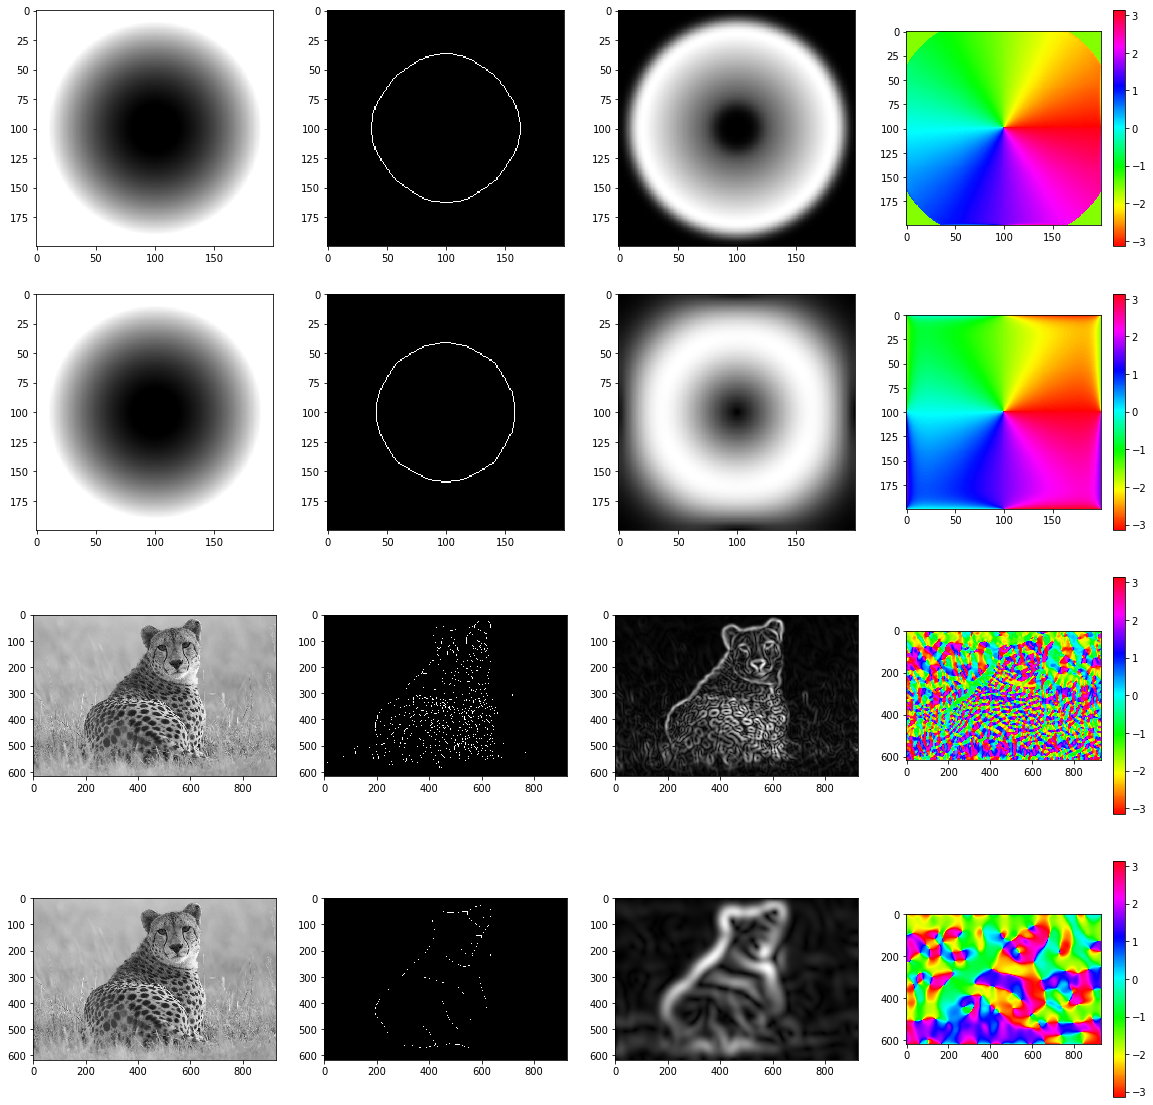

In [163]:
# set the plot figure size
fig = plt.figure(figsize=(20,20))

# synthetic test image for debugging purposes
[yy,xx] = np.mgrid[-100:100,-100:100]
image = np.minimum(np.maximum(np.array(xx*xx+yy*yy,dtype=float),400),8100)

image2 = plt.imread('cheetah.jpg')
image2 = rgb2gray(image2)

image_list = [image, image2]
sig = [5, 20]

j=1
for img in image_list:
    for sigma in sig:
        grad, theta, edges = detect_edge(img, sigma)
        fig.add_subplot(4,4,j)
        plt.imshow(img, cmap='gray')
        j+=1
        fig.add_subplot(4,4,j)
        plt.imshow(edges, cmap='gray')
        j+=1
        fig.add_subplot(4,4,j)
        plt.imshow(grad, cmap='gray')
        j+=1
        fig.add_subplot(4,4,j)
        plt.imshow(theta, cmap='hsv')
        plt.colorbar()
        j+=1


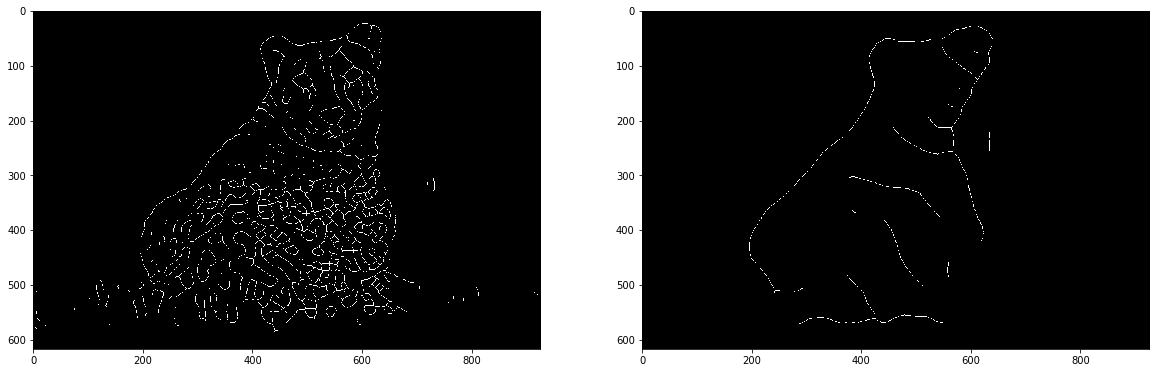

In [164]:
_, _, edges1 = detect_edge(image2, 5)
_, _, edges2 = detect_edge(image2, 20)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(edges1, cmap='gray')
plt.subplot(122)
plt.imshow(edges2, cmap='gray')

## 6. Template Detection

Implement a simple object detector based on cross-correlation.  Load in one
of the test images provided and display it on the screen.  Clip out a patch
of the image containing an object you want to detect.  Use this patch as a template
in order to try and detect other instances of the object in the image.

You should implement three different variants for computing a match score $S$
between the template $T$ and the image $I$. 

1. Cross-correlation: 

  $S(x,y) = \sum_{i,j} T[i,j]I[x+i,y+j]$


2. Normalized Cross-correlation: 

  $S(x,y) = \sum_{i,j} \frac{(T[i,j]-\mu_T)}{\sigma_T}\frac{(I[x+i,y+j]-\mu_{xy})}{\sigma_{xy}}$

  $\mu_{xy} = \frac{1}{N}\sum_{i,j} I[x+i,y+j]$

  $\sigma_{xy} = \sqrt{\frac{1}{N}\sum_{i,j} (I[x+i,y+j]-\mu_{xy})^2}$


3. Sum-of-squared-differences: 

  $S(x,y) = -\sum_{i,j} (T[i,j] - I[x+i,y+j])^2$

You can implement all of these quite effeciently using a couple convolutions and 
vectorized NumPy operations. When using convolution to perform cross-correlation, 
don't forget to flip the template left-right and top-bottom. To compute averages,
you can use convolution with a filter of all 1s the same size as your template.

You can try thresholding the resulting score map $S$ but you will note that
around detected objects there will be many pixels with high values.  In order to
suppress non-maximal responses, zero out any locations which are smaller than one
of their 8 neighbors. You can do this effeciently in NumPy using array indexing, 
e.g. in 1D this might look like:

$$
L = x[1:-1] > x[0:-2]   #bigger than our neighbor to the left?
R = x[1:-1] > x[2:]     #bigger than our neighbor to the right?
T = x[1:-1] > threshold #above detection threshold?
maxima = R & L & T
$$

It is also probably a good idea to set an upper limit on the number of detections your
function returns (e.g., so if you happen to call it with too low a threshold things
don't get overly slow).

### 6.1 Implementation

In [167]:
def xcorr(I, T):
    T_new = np.flipud(np.fliplr(T))
    S_xcorr = ndimage.convolve(I, T_new)
    
    return S_xcorr


def norm_xcorr(I, T):
    K = T.shape[0]
    k = int(K/2)
    I_padded = np.pad(I, k, 'edge')

    mu_T = np.mean(T)
    sigma_T = (T-mu_T)**2/np.size(T)

    T_norm = (T-mu_T)/sigma_T
    T_new = np.flipud(np.fliplr(T_norm))

    dummy_filter = np.ones(shape=T.shape)
    mu_xy = ndimage.convolve(I, dummy_filter)/np.size(T)

    sigma_xy = np.zeros(shape=I.shape)

    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            I_window = I_padded[x:x+K, y:y+K]
            sigma_xy[x][y] = np.sum((I_window-mu_xy[x][y])**2)

    sigma_xy = np.sqrt(sigma_xy/np.size(T))

    I_new = (I-mu_xy)/sigma_xy

    S_norm_xcorr = ndimage.convolve(I_new, T_new)
    
    return S_norm_xcorr


def ssd(I, T):
    K = T.shape[0]
    k = int(K/2)
    I_padded = np.pad(I, k, 'edge')

    S = np.zeros(shape=I.shape)

    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            I_window = I_padded[x:x+K, y:y+K]
            S[x][y] = -np.sum((T-I_window)**2)
            
    return S

In [168]:
# 
# suggestion on how to structure your code... feel free to
# ignore or modify as you see fit
#


def detect_template(I,template,thresh,ndetect,method):
    """
    Detect a object in an image by performing cross-correlation with the
    supplied template
    
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : 2D float array 
         Template we wish to match.
         
    thresh : float
        Score threshold above which we declare a positive match

    method : one of {'cc','ncc','ssd'}
        Method for comparing template and image patch
        
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
    
    heatmap : detection score map prior to non-max suppression

    """
    
    if method=='cc':
        S = xcorr(I, template)
    elif method=='ncc':
        S = norm_xcorr(I, template)
    elif method=='ssd':
        S = ssd(I, template)
        
    heatmap = S
    
    # non-maximum suppression on S
    K = template.shape[0]
    k = int(K/2)
    
    S_bool = feature.peak_local_max(S, min_distance=1, threshold_abs=thresh, indices=False)
    
    resp = S_bool*S
    
    # sort the values in resp in ascending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]] 
    
    val = np.sort(resp, axis=None)[::-1] # sorted response values
    ind = np.argsort(resp, axis=None)[::-1]  #corresponding indices
    
    scorelist = []
    
    for i in range(ndetect):
        # recover the x,y coordinates of the ith largest response
        [y,x] = np.unravel_index(ind[i], resp.shape)
        tmp = (x, y, S[y][x])
        scorelist.append(tmp)
    
    return scorelist, heatmap

### 6.2 Visualization and Discussion

Initially experiment with choosing a relatively small "object" such as Dilbert's nose or a 
single letter as your template. You can use the provided images but you should also experiment
with some image of your own choosing (ideally which contains more than one instance of the 
object of interest).

Plot the locations of above threshold local maxima on top of the original image using 
**patches.Rectangle**.  Experiment with the threshold to try to find a good tradeoff between 
detecting all the instances of an object and but not too many background detections.  Show 
a visualization of the template you used, the cross-correlation output using a false colormap 
(e.g. "jet"), and your final detection results.

Compare outputs of the three different methods (cc,ncc,ssd). You'll need to choose a different
threshold for each one. Discuss briefly which one appears to work the best and come up with 
an explanation as to why you think this is the case.

(15, 15)


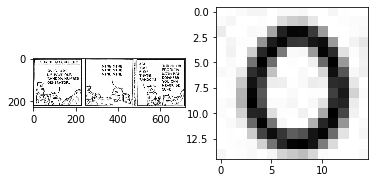

In [169]:
image = plt.imread('dilbert1.jpg')
image = rgb2gray(image)

template = image[70:85, 145:160]
print(template.shape)

plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.imshow(template, cmap='gray')

[(648, 23, 255), (39, 187, 255), (208, 130, 255), (515, 8, 255), (148, 78, 255), (537, 8, 255), (291, 200, 255), (216, 37, 255), (241, 200, 255), (254, 68, 255)]


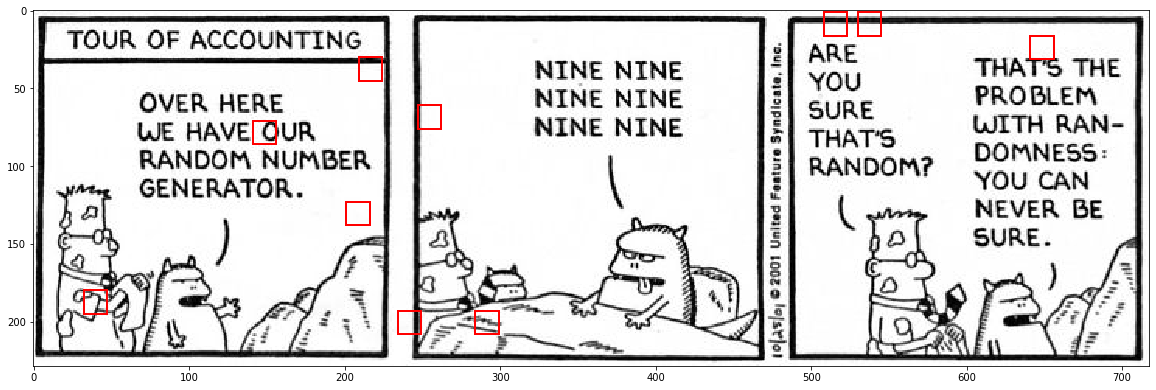

In [175]:
scorelist, heatmap = detect_template(image, template, 100, 10, 'cc')
print(scorelist)

plt.figure(figsize=(20,10))
plt.imshow(image, cmap=plt.cm.gray)
ax = plt.gca()
w = template.shape[1] #size of the template
h = template.shape[0] 
ct = 0
for (x,y,score) in scorelist:
    xc = x-(w//2)
    yc = y-(h//2)
    rect = patches.Rectangle((xc,yc),w,h,linewidth=2,edgecolor=np.array([1,0,0]),facecolor='none')
    ax.add_patch(rect)
    ct = ct + 1
plt.show()

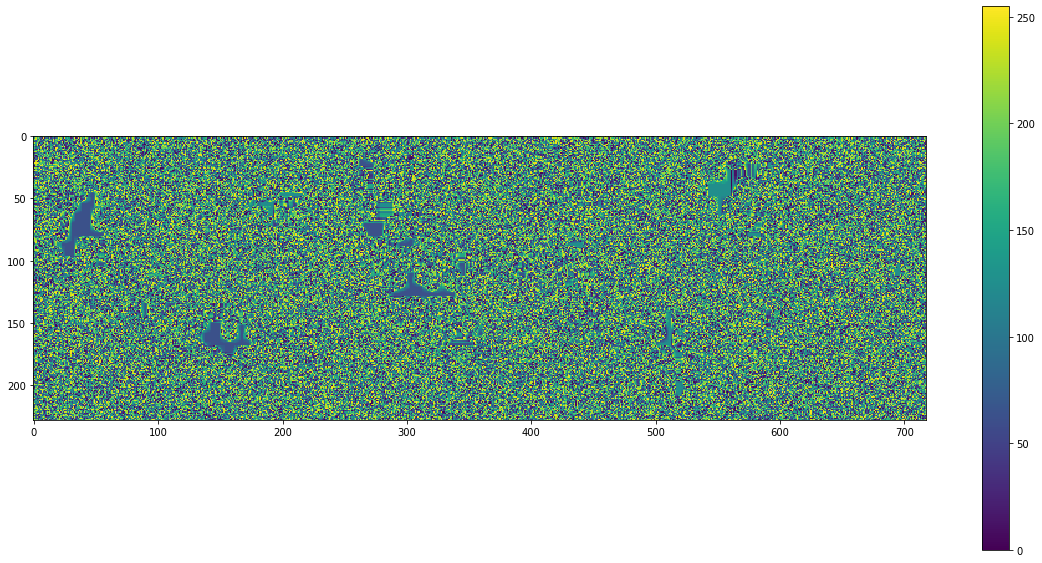

In [171]:
plt.figure(figsize=(20,10))
plt.imshow(heatmap)
plt.colorbar()

### Discussion

I'm not very sure about my implementation of the norm_xcorr and ssd functions so I won't comment on the results for those. However, even for the xcorr metric, the results vary a lot with different thresholds. Looking at the heatmap, I assume this might be because a lot of pixels have the maximum value which is passed as the threshold. In the detect_template function, the values are sorted according to the gradient values. Since a lot of them have the same value, and we are only choosing the first ndetect values, each call to the function returns different coordinates. It's not possible to judge a good threshold value because of this.